In [18]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split

from matplotlib import pyplot as plt
from PIL import Image


In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 定义数据预处理转换，包括数据增强操作
transform = transforms.Compose([
    transforms.RandomRotation(degrees=15),  # 随机旋转
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # 随机平移
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # 随机颜色变换
    # transforms.RandomHorizontalFlip(),  # 随机水平翻转
    transforms.ToTensor(),
])

dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)

# 定义训练集和测试集的比例
train_ration = 0.8
test_ration = 1 - train_ration

# 计算训练集和测试集的数量
train_size = int(train_ration * len(dataset))
test_size = len(dataset) - train_size

# 按照计算的数量随机划分训练集和测试集
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])


0 torch.Size([64, 1, 28, 28]) torch.Size([64])


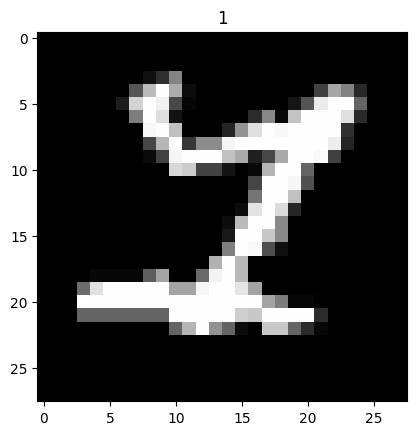

In [20]:
# 加载数据并查看数据
# from einops import rearrange

BATCH_SIZE = 64
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

for i, (images, labels) in enumerate(train_loader):
    print(i, images.shape, labels.shape)
    plt.imshow(images[0][0], cmap='gray')
    plt.title(labels[0].item())
    break


In [21]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # 卷积层提取图片特征
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, 3, 1, 1),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 16, 3, 1, 1),
            nn.ReLU()
        )
        
        # 添加更多的卷积层
        self.conv3 = nn.Sequential(
            nn.Conv2d(16, 32, 3, 1, 1),
            nn.ReLU()
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(32, 32, 3, 1, 1),
            nn.ReLU()
        )

        # 添加池化层
        # self.pool = nn.MaxPool2d(2, 2)
        
        self.fc_input_size = 32 * 28 * 28

        self.fc1 = nn.Sequential(nn.Linear(self.fc_input_size, 256), nn.Dropout(0.2), nn.ReLU())
        self.fc2 = nn.Sequential(nn.Linear(256, 128), nn.Dropout(0.2), nn.ReLU())
        self.fc3 = nn.Sequential(nn.Linear(128, 10), nn.Softmax(dim=1))

    def forward(self, x):
        x = self.conv1(x)
        # x = self.pool(x)
        x = self.conv2(x)
        # x = self.pool(x)
        x = self.conv3(x)
        # x = self.pool(x)
        x = self.conv4(x)
        # x = self.pool(x)

        x = x.view(x.shape[0], -1)

        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)

        return x


In [22]:
# 定义损失函数和优化器
model = CNN()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
lr=0.001 # 学习率
optimizer = optim.Adam(model.parameters(), lr)

In [ ]:
# 创建保存模型的目录
import os

save_path = './results/'
if not os.path.exists(save_path):
    os.makedirs(save_path)


In [51]:
from tqdm import tqdm

best_loss = float('inf')  # 初始化为正无穷大，确保第一个损失值一定会小于它

# 训练模型
def train():
    model.train()
    total_loss = 0 # 用于计算平均损失
    num_batches = len(train_loader) # 用于记录训练的batch数目

    with tqdm(total=num_batches, desc='Training', unit='batch') as pbar:
        for i, data in enumerate(train_loader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad() # 梯度清零
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward() # 反向传播
            optimizer.step() # 更新参数

            total_loss += loss.item()
            current_loss = loss.item()

            if i % 100 == 0:
                # print('Train Step: {}\tLoss: {:.3f}'.format(i, loss.item()))
                avg_loss = total_loss / (i + 1)
                pbar.set_postfix({'cur_loss': '{:.3f}'.format(loss), 'avg_loss':'{:.3f}'.format(avg_loss)})
                pbar.update(100) # 每处理100个batch更新一次tqdm
                # 判断当前损失是否比最佳损失小，如果是则保存模型状态
            if current_loss < best_loss:
                best_loss = current_loss
                torch.save(model.state_dict(), os.path.join(save_path, 'best_model.pth'))  # 保存模型
    
    print('Best loss:', best_loss)            


# 测试模型
def test():
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad(): # 测试过程中不需要计算梯度
        with tqdm(total=len(test_loader), desc="Testing", unit="batch") as pbar:
            for data in test_loader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, dim=1)
                total += labels.size(0)
                # print(predicted.shape, labels.shape)
                correct += (predicted == labels).sum().item()
                pbar.update(1)# 每处理1个batch更新一次tqdm

    print('Accuracy on test set: {:.3f}'.format(correct / total))

print('Before training:', end=' ')
test()

Before training: 

Testing: 100%|██████████| 188/188 [00:03<00:00, 47.01batch/s]

Accuracy on test set: 0.946


In [52]:
EPOCH = 5
# 训练5个epoch
for epoch in range(EPOCH):
    print('epoch {}'.format(epoch + 1))
    train()
    test()

epoch 1


Training: 800batch [00:21, 37.61batch/s, cur_loss=1.508, avg_loss=1.529]                      


Best loss: 1.4611512422561646


Testing: 100%|██████████| 188/188 [00:03<00:00, 48.22batch/s]


Accuracy on test set: 0.943
epoch 2


Training: 800batch [00:22, 35.44batch/s, cur_loss=1.510, avg_loss=1.527]                      


Best loss: 1.4611507654190063


Testing: 100%|██████████| 188/188 [00:03<00:00, 49.36batch/s]


Accuracy on test set: 0.945
epoch 3


Training: 800batch [00:21, 37.10batch/s, cur_loss=1.551, avg_loss=1.527]                      


Best loss: 1.4611507654190063


Testing: 100%|██████████| 188/188 [00:03<00:00, 55.01batch/s]


Accuracy on test set: 0.944
epoch 4


Training: 800batch [00:18, 42.57batch/s, cur_loss=1.559, avg_loss=1.527]                      


Best loss: 1.4611519575119019


Testing: 100%|██████████| 188/188 [00:03<00:00, 55.37batch/s]


Accuracy on test set: 0.945
epoch 5


Training: 800batch [00:19, 41.12batch/s, cur_loss=1.515, avg_loss=1.529]                      


Best loss: 1.4611510038375854


Testing: 100%|██████████| 188/188 [00:03<00:00, 49.00batch/s]

Accuracy on test set: 0.944


In [37]:
# 保存最后一次模型

torch.save(model.state_dict(), os.path.join(save_path, 'model.pth'))

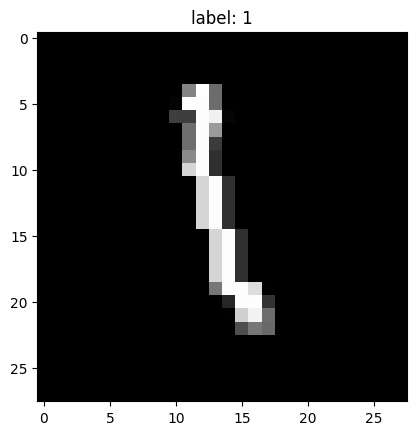

predict: 1


In [56]:
# 加载模型
model = CNN()
model.load_state_dict(torch.load(os.path.join(save_path, 'best_model.pth')))
model = model.to(device)

# 预测
def predict(img):
    model.eval()
    img = img.to(device)
    with torch.no_grad():
        output = model(img)
        # print(output)
        _, predicted = torch.max(output.data, dim=1)
        return predicted.item()
    
import random
# 随机选取一张图片进行预测
index = random.randint(0, len(test_dataset))
img = test_dataset[index][0].unsqueeze(0)
label = test_dataset[index][1]
plt.imshow(img[0][0], cmap='gray')
plt.title('label: {}'.format(label))
plt.show()
print('predict: {}'.format(predict(img)))

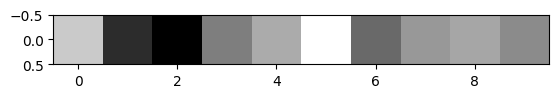

Testing: 100%|██████████| 188/188 [00:03<00:00, 49.46batch/s]

Accuracy on test set: 0.946


In [60]:
a = torch.randn(1, 10)
plt.imshow(a, cmap='gray')
plt.show()
# print(a)
# print(torch.sum(a))
# print(torch.max(a, dim=1))
test()

Original shape:  (2502, 3230)
torch.Size([1, 28, 28])


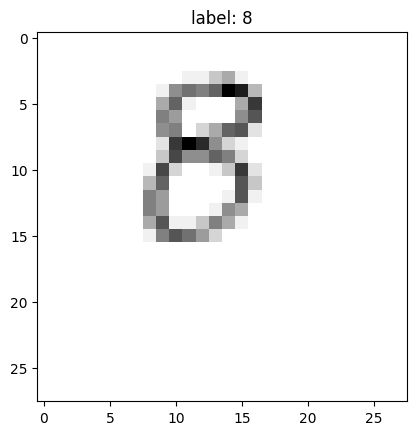

predict: 8


In [63]:
from PIL import Image

img = Image.open('./8.jpg')

transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.Grayscale(),
    transforms.ToTensor(),
])

print("Original size: ", img.size)
img = transform(img)
print(img.shape)
plt.title('label: 8')
plt.imshow(img[0], cmap='gray')
plt.show()

print('predict: {}'.format(predict(img.unsqueeze(0))))